# Modern VQGAN+CLIP (2025)

Text-to-image generation using VQGAN+CLIP with modern PyTorch 2.9, OpenCLIP, and optimizations.

**Key Features:**
- OpenCLIP models trained on LAION-2B
- Mixed precision (bfloat16/float16/float32 auto-detection)
- AdamW optimizer with cosine annealing
- Supports Apple Silicon (MPS), CUDA (T4, A100, etc.), and CPU
- Modular architecture for easy customization

## 1. Setup and Installation

**This notebook is 100% STANDALONE!**

Just run the cells in order - all supporting files are automatically cloned from GitHub.

**What happens automatically:**
1. Cell 2: Clones project repository with all supporting files
2. Cell 2: Installs dependencies from requirements.txt
3. Cell 2: Clones and patches taming-transformers for PyTorch 2.x
4. Cell 4: Interactive configuration with sliders/dropdowns

**Requirements:**
- VQGAN models in `./models/` directory:
  - `vqgan_imagenet_f16_16384.yaml`
  - `vqgan_imagenet_f16_16384.ckpt`
  - Download from: https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/

**First run:** Takes 5-10 minutes for cloning and installation. Restart kernel after Cell 2.

In [ ]:
# ============================================================================
# AUTOMATIC SETUP: Clone Repository + Install Dependencies
# This cell clones the project repo and installs all dependencies automatically
# ============================================================================

import subprocess
import sys
import os
import shutil
from pathlib import Path

# ============================================================================
# CONFIGURATION
# ============================================================================
REPO_URL = "https://github.com/MattKevan/VQ"
# Use /mnt/store to persist across kernel restarts
REPO_DIR = Path("/mnt/store/vqgan-clip")
TAMING_DIR = Path("/mnt/store/taming-transformers")

print("🚀 Modern VQGAN+CLIP Setup")
print("=" * 60)

# Create /mnt/store directory if it doesn't exist
REPO_DIR.parent.mkdir(parents=True, exist_ok=True)

# ============================================================================
# Step 1: Clone Project Repository
# ============================================================================
print(f"\n📦 Step 1: Setting up project repository...")

if REPO_DIR.exists():
    print(f"   ✓ Repository already exists at {REPO_DIR}")
    print(f"   (Delete {REPO_DIR} to force fresh clone)")
else:
    print(f"   Cloning to {REPO_DIR}...")
    try:
        subprocess.check_call(
            ["git", "clone", REPO_URL, str(REPO_DIR)],
            stdout=subprocess.DEVNULL,
            stderr=subprocess.STDOUT
        )
        print(f"   ✓ Cloned repository to {REPO_DIR}")
    except Exception as e:
        print(f"   ✗ Failed to clone repository: {e}")
        print(f"   Please check that git is installed and {REPO_URL} is accessible")
        raise

# Verify required files exist
required_files = [
    REPO_DIR / "vqgan_clip_utils.py",
    REPO_DIR / "requirements.txt"
]
for file in required_files:
    if not file.exists():
        print(f"   ✗ Missing required file: {file}")
        raise FileNotFoundError(f"Repository is missing {file}")
print(f"   ✓ All required files present")

# ============================================================================
# Step 2: Install Dependencies from requirements.txt
# ============================================================================
print(f"\n📚 Step 2: Installing dependencies from requirements.txt...")

def install_package(package):
    """Install a package using pip - show errors if they occur"""
    try:
        result = subprocess.run(
            [sys.executable, "-m", "pip", "install", "-q", package],
            capture_output=True,
            text=True,
            check=True
        )
        return True, None
    except subprocess.CalledProcessError as e:
        return False, e.stderr

try:
    with open(REPO_DIR / "requirements.txt", 'r') as f:
        packages = [line.strip() for line in f if line.strip() and not line.startswith('#')]
    
    failed_packages = []
    for package in packages:
        pkg_name = package.split('>=')[0].split('==')[0].split(',')[0]
        success, error = install_package(package)
        
        if success:
            print(f"   ✓ {pkg_name}")
        else:
            print(f"   ✗ Failed to install {pkg_name}")
            if error:
                print(f"      Error: {error[:200]}")  # Show first 200 chars of error
            failed_packages.append((pkg_name, error))
    
    if failed_packages:
        print(f"\n   ⚠️  {len(failed_packages)} package(s) failed to install:")
        for pkg, err in failed_packages:
            print(f"      - {pkg}")
    else:
        print(f"   ✓ All dependencies installed successfully")
        
except Exception as e:
    print(f"   ✗ Failed to install dependencies: {e}")
    raise

# ============================================================================
# Step 3: Clone and Patch taming-transformers
# ============================================================================
print(f"\n🔧 Step 3: Setting up taming-transformers...")

try:
    # Clone if not exists
    if TAMING_DIR.exists():
        print(f"   ✓ taming-transformers already exists at {TAMING_DIR}")
    else:
        print(f"   Cloning to {TAMING_DIR}...")
        subprocess.check_call(
            ["git", "clone", "https://github.com/CompVis/taming-transformers.git", str(TAMING_DIR)],
            stdout=subprocess.DEVNULL,
            stderr=subprocess.STDOUT
        )
        print("   ✓ Cloned taming-transformers")
    
    # Apply PyTorch 2.x compatibility fix
    utils_file = TAMING_DIR / "taming/data/utils.py"
    if utils_file.exists():
        with open(utils_file, 'r') as f:
            content = f.read()
        
        if 'from torch._six import string_classes' in content:
            content = content.replace(
                'from torch._six import string_classes',
                '# torch._six was removed in PyTorch 2.0\nstring_classes = str'
            )
            with open(utils_file, 'w') as f:
                f.write(content)
            print("   ✓ Applied PyTorch 2.x compatibility fix")
        else:
            print("   ✓ PyTorch 2.x patch already applied")
except Exception as e:
    print(f"   ✗ Failed to setup taming-transformers: {e}")
    raise

# ============================================================================
# Step 4: Verify open-clip installation
# ============================================================================
print(f"\n🔍 Step 4: Verifying critical imports...")

try:
    import torch
    print(f"   ✓ torch {torch.__version__}")
except ImportError as e:
    print(f"   ✗ torch import failed: {e}")

try:
    import open_clip
    print(f"   ✓ open_clip (imported as 'open_clip')")
except ImportError:
    try:
        import open_clip_torch
        print(f"   ✓ open_clip_torch (package installed, use: import open_clip_torch as open_clip)")
    except ImportError as e:
        print(f"   ✗ open_clip/open_clip_torch import failed: {e}")
        print(f"      Try manually: pip install open-clip-torch")

# ============================================================================
# Setup Complete
# ============================================================================
print("\n" + "=" * 60)
print("✅ Setup complete!")
print("=" * 60)
print(f"\n📁 Project files location: {REPO_DIR}/")
print(f"   - vqgan_clip_utils.py")
print(f"   - requirements.txt")
print(f"   - config.yaml (if present)")
print(f"\n📁 Taming-transformers location: {TAMING_DIR}/")
print(f"\n💡 Files persist in /mnt/store across kernel restarts")
print(f"   To update: delete {REPO_DIR} and re-run this cell")
print("\n⚠️  IMPORTANT: Restart kernel now, then continue with Cell 3")
print("=" * 60)

In [ ]:
import torch
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datetime import datetime
import sys
import os

# ============================================================================
# Add cloned repositories to Python path
# ============================================================================
REPO_DIR = Path("/mnt/store/vqgan-clip")
TAMING_DIR = Path("/mnt/store/taming-transformers")

# Add vqgan-clip repository
if REPO_DIR.exists() and str(REPO_DIR) not in sys.path:
    sys.path.insert(0, str(REPO_DIR))
    print(f"✓ Added {REPO_DIR} to Python path")
else:
    if not REPO_DIR.exists():
        print(f"⚠️  Warning: {REPO_DIR} not found")
        print(f"   Please run Cell 2 (Setup) first!")

# Add taming-transformers repository
if TAMING_DIR.exists() and str(TAMING_DIR) not in sys.path:
    sys.path.insert(0, str(TAMING_DIR))
    print(f"✓ Added {TAMING_DIR} to Python path")
else:
    if not TAMING_DIR.exists():
        print(f"⚠️  Warning: {TAMING_DIR} not found")
        print(f"   Please run Cell 2 (Setup) first!")

# Import utilities from cloned repository
try:
    import vqgan_clip_utils as vcu
    print(f"✓ Loaded vqgan_clip_utils from {REPO_DIR}/")
except ImportError as e:
    print(f"✗ Error loading vqgan_clip_utils: {e}")
    print(f"\nTroubleshooting:")
    print(f"  1. Make sure Cell 2 completed successfully")
    print(f"  2. Restart kernel after running Cell 2")
    print(f"  3. Check that {REPO_DIR / 'vqgan_clip_utils.py'} exists")
    raise

# For notebook display
from IPython.display import display, clear_output

print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    print("Apple Silicon (MPS) available")
else:
    print("Using CPU")

## 3. Configuration (Interactive)

Adjust settings using the interactive controls below, or modify the config dictionary directly in the next cell.

In [ ]:
# ============================================================================
# INTERACTIVE CONFIGURATION with ipywidgets
# ============================================================================

try:
    import ipywidgets as widgets
    from IPython.display import display
    USE_WIDGETS = True
except ImportError:
    USE_WIDGETS = False
    print("ipywidgets not available - using default config")
    print("Install with: pip install ipywidgets")

# Default configuration
config = {
    'vqgan': {
        'config_path': 'models/vqgan_imagenet_f16_16384.yaml',
        'checkpoint_path': 'models/vqgan_imagenet_f16_16384.ckpt'
    },
    'clip': {
        'model_name': 'ViT-B-32',
        'pretrained': 'laion2b_s34b_b79k'
    },
    'image': {
        'width': 256,
        'height': 256,
        'seed': None
    },
    'optimization': {
        'iterations': 100,
        'learning_rate': 0.1,
        'weight_decay': 0.01,
        'use_mixed_precision': True,
        'scheduler': {'type': 'cosine', 'eta_min_ratio': 0.01},
        'optimizer': 'AdamW'
    },
    'cutouts': {
        'num_cuts': 16,
        'cut_power': 1.0,
        'method': 'original',
        'augmentations': {'affine_prob': 0.5, 'jitter_prob': 0.5, 'noise_prob': 0.1}
    },
    'device': {
        'type': 'auto',
        'gpu_id': 0
    },
    'output': {
        'save_every': 25,
        'output_dir': 'outputs',
        'filename_prefix': 'vqgan_clip',
        'format': 'png'
    }
}

if USE_WIDGETS:
    print("📊 Interactive Configuration")
    print("=" * 50)
    
    # Create widgets
    device_widget = widgets.Dropdown(
        options=['auto', 'cpu', 'cuda', 'mps'],
        value=config['device']['type'],
        description='Device:',
        style={'description_width': '150px'}
    )
    
    size_widget = widgets.Dropdown(
        options=[128, 256, 384, 512, 768],
        value=config['image']['width'],
        description='Image Size:',
        style={'description_width': '150px'}
    )
    
    iterations_widget = widgets.IntSlider(
        value=config['optimization']['iterations'],
        min=50, max=2000, step=50,
        description='Iterations:',
        style={'description_width': '150px'}
    )
    
    cuts_widget = widgets.IntSlider(
        value=config['cutouts']['num_cuts'],
        min=8, max=128, step=8,
        description='Cutouts:',
        style={'description_width': '150px'}
    )
    
    lr_widget = widgets.FloatSlider(
        value=config['optimization']['learning_rate'],
        min=0.01, max=0.3, step=0.01,
        description='Learning Rate:',
        style={'description_width': '150px'}
    )
    
    method_widget = widgets.Dropdown(
        options=['original', 'kornia'],
        value=config['cutouts']['method'],
        description='Cutout Method:',
        style={'description_width': '150px'}
    )
    
    # Display widgets
    print("\n⚙️  Adjust settings:")
    display(widgets.VBox([
        widgets.HTML("<b>Hardware</b>"),
        device_widget,
        widgets.HTML("<br><b>Image Settings</b>"),
        size_widget,
        widgets.HTML("<br><b>Optimization</b>"),
        iterations_widget,
        cuts_widget,
        lr_widget,
        widgets.HTML("<br><b>Advanced</b>"),
        method_widget
    ]))
    
    # Update config function
    def update_config():
        config['device']['type'] = device_widget.value
        config['image']['width'] = size_widget.value
        config['image']['height'] = size_widget.value
        config['optimization']['iterations'] = iterations_widget.value
        config['cutouts']['num_cuts'] = cuts_widget.value
        config['optimization']['learning_rate'] = lr_widget.value
        config['cutouts']['method'] = method_widget.value
    
    # Auto-update on change
    for widget in [device_widget, size_widget, iterations_widget, cuts_widget, lr_widget, method_widget]:
        widget.observe(lambda change: update_config(), names='value')
    
    update_config()
    
    print("\n✅ Configuration ready! Widgets update config automatically.")
    print("   Run next cell to load models.")

else:
    print("\n⚙️  Using default safe config:")

print(f"\n📋 Current Settings:")
print(f"  Device: {config['device']['type']}")
print(f"  Image size: {config['image']['width']}x{config['image']['height']}")
print(f"  Iterations: {config['optimization']['iterations']}")
print(f"  Learning rate: {config['optimization']['learning_rate']}")
print(f"  Cutouts: {config['cutouts']['num_cuts']}")
print(f"  Method: {config['cutouts']['method']}")
print(f"  CLIP model: {config['clip']['model_name']}")

print(f"\n💡 Tip: For Apple Silicon, use 'cpu' device if MPS crashes.")

## 4. Initialize Device and Load Models

Auto-detect the best available device (CUDA GPU, Apple Silicon MPS, or CPU) and load VQGAN + OpenCLIP models.

In [4]:
# Device configuration
device, dtype = vcu.get_device(config['device']['type'], config['device']['gpu_id'])
print(f"\nUsing device: {device}")
print(f"Mixed precision dtype: {dtype}")

# Load VQGAN
print("\nLoading VQGAN...")
vqgan_model = vcu.load_vqgan(
    config['vqgan']['config_path'],
    config['vqgan']['checkpoint_path'],
    device
)

# Load OpenCLIP
print("\nLoading OpenCLIP...")
clip_model, clip_preprocess, clip_tokenizer = vcu.load_clip(
    config['clip']['model_name'],
    config['clip']['pretrained'],
    device
)

print("\nModels loaded successfully!")

Using Apple Silicon (MPS) with float32

Using device: mps
Mixed precision dtype: torch.float32

Loading VQGAN...
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/Users/mattkevan/Dev/VQ/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mattkevan/Dev/VQ/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Applying MPS compatibility wrapper for VQGAN (model kept on CPU)...
Loaded VQGAN from models/vqgan_imagenet_f16_16384.ckpt

Loading OpenCLIP...
Loaded OpenCLIP ViT-B-32 with laion2b_s34b_b79k weights

Models loaded successfully!


## 5. Configuration: Define Your Generation Parameters

Customize your generation settings here.

In [5]:
# ============================================================================
# GENERATION PARAMETERS - Customize these!
# ============================================================================

# Text prompts (can use multiple with weights)
text_prompts = [
    "a beautiful landscape painting of mountains at sunset",
    "trending on artstation:0.5",
    "highly detailed:0.3"
]

# Image settings - REDUCED FOR MPS STABILITY
image_width = 256  # Reduced from 512 for MPS stability
image_height = 256  # Reduced from 512 for MPS stability
seed = 42  # Set to None for random, or integer for reproducibility

# Optimization
iterations = 100  # Reduced from 500 for initial testing
learning_rate = 0.1
weight_decay = 0.01
use_scheduler = True  # Cosine annealing

# Cutouts - REDUCED FOR MPS STABILITY
num_cuts = 16  # Reduced from 32 for MPS stability
cut_power = 1.0  # <1.0 = bigger cutouts, >1.0 = smaller
cutout_method = "original"  # Force 'original' for MPS (kornia will auto-switch anyway)

# Initialization (optional)
init_image_path = None  # Path to seed image, or None for random noise
init_weight = 0.0  # 0.0-1.0, how much to preserve init image

# Output
save_every = 25  # Save progress images every N iterations (0 to disable)
output_dir = "outputs"

print("Generation parameters configured!")
print(f"Prompts: {len(text_prompts)} text prompts")
print(f"Size: {image_width}x{image_height}")
print(f"Iterations: {iterations}")
print(f"Cutouts: {num_cuts}")
print("\n⚠️  MPS STABILITY NOTE:")
print("   Settings optimized for Apple Silicon stability")
print("   Start small (256x256, 16 cuts) and scale up gradually")

Generation parameters configured!
Prompts: 3 text prompts
Size: 256x256
Iterations: 100
Cutouts: 16

⚠️  MPS STABILITY NOTE:
   Settings optimized for Apple Silicon stability
   Start small (256x256, 16 cuts) and scale up gradually


## 6. Prepare for Generation

Encode prompts and initialize the cutout generator.

In [6]:
# Encode text prompts
print("Encoding text prompts...")
text_features = vcu.encode_prompts(
    text_prompts,
    clip_model,
    clip_tokenizer,
    device
)
print(f"Text features shape: {text_features.shape}")

# MPS compatibility: Force 'original' cutout method on Apple Silicon
# Kornia augmentations don't support backward pass on MPS
if device.type == "mps" and cutout_method == "kornia":
    print("Note: Switching to 'original' cutout method for MPS compatibility")
    print("      (Kornia augmentations don't support backward pass on MPS)")
    cutout_method = "original"

# Initialize cutout generator
if cutout_method == "kornia":
    make_cutouts = vcu.MakeCutoutsKornia(
        cut_size=224,
        num_cuts=num_cuts,
        cut_power=cut_power,
        affine_prob=config['cutouts']['augmentations']['affine_prob'],
        jitter_prob=config['cutouts']['augmentations']['jitter_prob'],
        noise_prob=config['cutouts']['augmentations']['noise_prob'],
        use_mps=(device.type == "mps")  # MPS compatibility for Apple Silicon
    ).to(device)
else:
    make_cutouts = vcu.MakeCutoutsOriginal(
        cut_size=224,
        num_cuts=num_cuts,
        cut_power=cut_power
    ).to(device)

print(f"Using '{cutout_method}' cutout method")

# Create optimizer
optimizer = vcu.VQGANCLIPOptimizer(
    vqgan_model=vqgan_model,
    clip_model=clip_model,
    text_features=text_features,
    device=device,
    dtype=dtype,
    make_cutouts=make_cutouts,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    use_scheduler=use_scheduler,
    iterations=iterations
)

# Initialize latent vector
print("\nInitializing latent vector...")
z = optimizer.initialize_latent(
    size=(image_width, image_height),
    init_image=init_image_path,
    init_weight=init_weight,
    seed=seed
)
print(f"Latent shape: {z.shape}")
print("\nReady to generate!")

Encoding text prompts...
Text features shape: torch.Size([3, 512])
Using 'original' cutout method

Initializing latent vector...
Latent shape: torch.Size([1, 256, 16, 16])

Ready to generate!


## 7. Generate Image

Run the optimization loop to generate your image. Progress will be displayed with periodic previews.

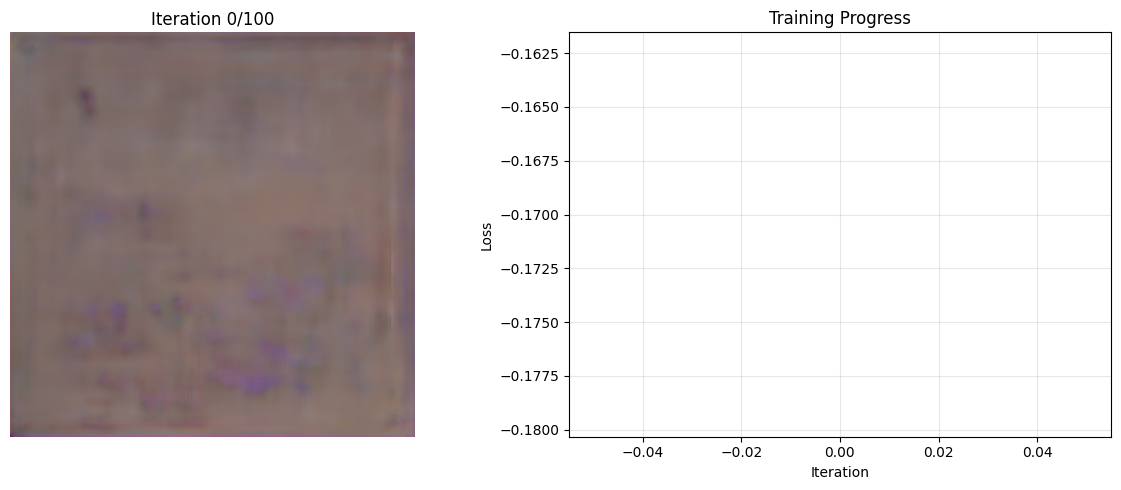

Generating:  27%|██▋       | 27/100 [23:36<1:03:49, 52.45s/it, loss=-0.2677]


KeyboardInterrupt: 

In [7]:
# Create output directory
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_output_dir = Path(output_dir) / timestamp
run_output_dir.mkdir(parents=True, exist_ok=True)

print(f"Output directory: {run_output_dir}")
print(f"Starting generation for {iterations} iterations...\n")

# Training loop with progress bar
pbar = tqdm(range(iterations), desc="Generating")
loss_history = []

for i in pbar:
    # Optimization step
    out, loss = optimizer.step(i)
    loss_history.append(loss)
    
    # Update progress bar
    pbar.set_postfix({'loss': f'{loss:.4f}'})
    
    # Save and display progress
    if save_every > 0 and (i % save_every == 0 or i == iterations - 1):
        img = optimizer.decode_current()
        
        # Save
        save_path = run_output_dir / f"step_{i:04d}.png"
        img.save(save_path)
        
        # Display in notebook
        if i % (save_every * 2) == 0 or i == iterations - 1:
            clear_output(wait=True)
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            
            # Show image
            axes[0].imshow(img)
            axes[0].set_title(f"Iteration {i}/{iterations}")
            axes[0].axis('off')
            
            # Show loss curve
            axes[1].plot(loss_history)
            axes[1].set_xlabel('Iteration')
            axes[1].set_ylabel('Loss')
            axes[1].set_title('Training Progress')
            axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()

print(f"\nGeneration complete!")
print(f"Final loss: {loss_history[-1]:.4f}")
print(f"Images saved to: {run_output_dir}")

## 8. Display Final Result

In [ ]:
# Get final image
final_image = optimizer.decode_current()

# Save final result
final_path = run_output_dir / "final.png"
final_image.save(final_path)
print(f"Final image saved: {final_path}")

# Display
plt.figure(figsize=(10, 10))
plt.imshow(final_image)
plt.axis('off')
plt.title("Final Generated Image", fontsize=16)
plt.tight_layout()
plt.show()

# Display prompts used
print("\nPrompts used:")
for i, prompt in enumerate(text_prompts, 1):
    print(f"  {i}. {prompt}")

## 9. Loss Analysis (Optional)

In [ ]:
# Plot detailed loss curve
plt.figure(figsize=(12, 6))
plt.plot(loss_history, linewidth=0.5, alpha=0.6, label='Raw loss')

# Add smoothed curve
import numpy as np
window = min(50, len(loss_history) // 10)
if window > 0:
    smoothed = np.convolve(loss_history, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(loss_history)), smoothed, 
             linewidth=2, color='red', label=f'Smoothed (window={window})')

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Over Time', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Starting loss: {loss_history[0]:.4f}")
print(f"Final loss: {loss_history[-1]:.4f}")
print(f"Improvement: {((loss_history[0] - loss_history[-1]) / loss_history[0] * 100):.1f}%")

## 10. Quick Re-run with Different Settings

This cell lets you quickly generate another image with modified parameters without reloading models.

In [ ]:
# Modify parameters for new generation
new_prompts = [
    "abstract digital art, vibrant colors",
    "cyberpunk style:0.7"
]

new_iterations = 300
new_seed = None  # Random

# Re-encode prompts
text_features = vcu.encode_prompts(new_prompts, clip_model, clip_tokenizer, device)

# Recreate cutouts if needed (or reuse existing make_cutouts)
# For this example, we'll reuse the existing make_cutouts object

# Create new optimizer
optimizer = vcu.VQGANCLIPOptimizer(
    vqgan_model=vqgan_model,
    clip_model=clip_model,
    text_features=text_features,
    device=device,
    dtype=dtype,
    make_cutouts=make_cutouts,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    use_scheduler=use_scheduler,
    iterations=new_iterations
)

# Initialize latent
z = optimizer.initialize_latent(
    size=(image_width, image_height),
    seed=new_seed
)

# Generate
print(f"Generating with new prompts for {new_iterations} iterations...")
for i in tqdm(range(new_iterations)):
    out, loss = optimizer.step(i)

# Display result
result = optimizer.decode_current()
plt.figure(figsize=(8, 8))
plt.imshow(result)
plt.axis('off')
plt.title(f"New Generation\n{new_prompts[0][:50]}...", fontsize=12)
plt.show()

# Save
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
result.save(Path(output_dir) / f"quick_gen_{timestamp}.png")
print(f"Saved to: {output_dir}/quick_gen_{timestamp}.png")

## 11. Experimental: Custom Cutout Patterns (Future)

This section is a placeholder for implementing custom structured cutout sampling patterns.
The current architecture makes it easy to extend the cutout generation.

In [ ]:
# TODO: Implement custom cutout patterns here
# Examples:
# - Grid-based sampling (evenly spaced cutouts)
# - Radial patterns (concentric circles)
# - Golden ratio spiral patterns
# - Importance map-based sampling
# - Hierarchical multi-scale patterns

# The MakeCutoutsKornia class in vqgan_clip_utils.py can be extended
# or subclassed to implement these patterns.

print("Custom cutout patterns not yet implemented.")
print("This is where systematic compositional control will be added!")

## Tips and Best Practices

### Prompt Engineering
- More detailed prompts generally work better
- Use weights to balance multiple concepts: `"mountains:1.5 | ocean:0.8"`
- Add style qualifiers: "trending on artstation", "highly detailed", "4k"
- Reference artists: "in the style of [artist name]"

### Performance Tuning
- **Iterations**: 100-500 for quick tests, 1000-5000 for quality, 5000-10000 for high quality
- **Cutouts**: More cutouts = better quality but slower (16-32 fast, 64-128 quality)
- **Learning Rate**: Lower (0.05) for init images, higher (0.15-0.2) for from-scratch
- **Image Size**: Start small (256x256) for testing, then scale up

### Device-Specific Notes
- **Apple Silicon (MPS)**: Uses float32 only, good for testing
- **T4 GPU**: Good for 256-512px, use float16
- **A100/H100**: Full performance, native bfloat16, can handle 768px+

### Troubleshooting
- **Out of Memory**: Reduce image size, num_cuts, or use CPU
- **Poor results**: Increase iterations, adjust learning rate, refine prompts
- **Training instability**: Lower learning rate, increase init_weight if using init image